In [1]:
import pandas as pd
import numpy as np

In [2]:
ratings = pd.read_csv("2 ratings.csv")
movies = pd.read_csv("4 movies.csv", low_memory=False)

In [3]:
# Get rid of ratings without movie, bad ratings, and movies without rating
ratings = ratings[ratings['movieId'].isin(movies['id'])]
ratings = ratings[ratings['rating'] > 2.5]
movies = movies[movies['id'].isin(ratings['movieId'])]

In [47]:
###
# ratings.to_csv("3 ratings_bicluster.csv", index=False)
# movies.to_csv("5 movies_bicluster.csv", index=False)

# Cramér's V

In [240]:
import pandas as pd
import numpy as np
import random

In [15]:
ratings = pd.read_csv("3 ratings_bicluster.csv")
movies = pd.read_csv("5 movies_bicluster.csv", low_memory=False)

In [16]:
nuserClusters = 10
nmovieClusters = 4

In [17]:
# Random clusters
userCluster = ratings['userId'].apply(lambda x: x % nuserClusters)
movieCluster = ratings['movieId'].apply(lambda x: x % nmovieClusters)

In [18]:
ratings['userCluster'] = userCluster
ratings['movieCluster'] = movieCluster

In [19]:
userMatrix = np.zeros((nmovieClusters,nuserClusters))
movieMatrix = np.zeros((nmovieClusters,nuserClusters))

In [20]:
# Strength of connection from user's clusters perspective
# Number of connections between i. movie cluster and j. user cluster / all connections of j. user(!) cluster
for i in range(nmovieClusters):
    for j in range (nuserClusters):
        userMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & (ratings['userCluster'] == j)].shape[0] / ratings[ratings['userCluster'] == j].shape[0]

In [21]:
# Strength of connection from movies's clusters perspective
# Number of connections between i. movie cluster and j. user cluster / all connections of i. movie(!) cluster
for i in range(nmovieClusters):
    for j in range (nuserClusters):
        movieMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & (ratings['userCluster'] == j)].shape[0] / ratings[ratings['movieCluster'] == i].shape[0]

In [22]:
relationMatrix = (userMatrix + movieMatrix) / 2

In [23]:
# Cramér's V
V = 0
n = np.sum(relationMatrix)
for i in range(nmovieClusters):
    for j in range (nuserClusters):
        p = np.sum(relationMatrix, axis=0)[j] * np.sum(relationMatrix, axis=1)[i] / n
        V = V + (relationMatrix[i,j] - p)**2 / p

In [24]:
V = np.sqrt(V / n / min(nmovieClusters - 1, nuserClusters - 1))

In [25]:
V

0.0007432686132471521

# Cramér's V Score comparison

In [20]:
import pandas as pd
import numpy as np
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch
from sklearn.decomposition import PCA

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings_birch = pd.read_csv("3 ratings_bicluster.csv")
ratings_random = pd.read_csv("3 ratings_bicluster.csv")
movies = pd.read_csv("5 movies_bicluster.csv", low_memory=False)

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    movieids = movies['id']
    movies = movies.drop(['id', 'title'], axis=1)
    
    # Categorical values are not used, because of the algorithm
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric)
    movievectors.index = movieids
    
    return movievectors

In [4]:
def cramerv(ratings, nmovieClusters, nuserClusters):
    
    userMatrix = np.zeros((nmovieClusters,nuserClusters))
    movieMatrix = np.zeros((nmovieClusters,nuserClusters))
    
    # Strength of connection from user's clusters perspective
    # Number of connections between i. movie cluster and j. user cluster / all connections of j. user(!) cluster
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            userMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & 
                                      (ratings['userCluster'] == j)].shape[0] / ratings[ratings['userCluster'] == j].shape[0]
            
    # Strength of connection from movies's clusters perspective
    # Number of connections between i. movie cluster and j. user cluster / all connections of i. movie(!) cluster
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            movieMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & 
                                       (ratings['userCluster'] == j)].shape[0] / ratings[ratings['movieCluster'] == i].shape[0]
            
    relationMatrix = (userMatrix + movieMatrix) / 2
    
    # Cramér's V
    V = 0
    n = np.sum(relationMatrix)
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            p = np.sum(relationMatrix, axis=0)[j] * np.sum(relationMatrix, axis=1)[i] / n
            V = V + (relationMatrix[i,j] - p)**2 / p
            
    V = np.sqrt(V / n / min(nmovieClusters - 1, nuserClusters - 1))
    
    return V
    
def movieid_to_cluster(movieid):
    reduced = pca.transform(np.array(movies.loc[movieid]).reshape(1, -1))
    cluster = birch.predict(reduced)
    cluster = cluster[0]
    
    return cluster

In [23]:
###

In [5]:
# Use the best previous movie clustering solution
movies = prepare_dataframe(movies)

pca = PCA(n_components=39)
reduced_data_PCA = pca.fit_transform(movies)

for thres in np.arange(0.5, 0, -0.05):
    try:
        birch = Birch(threshold=thres)
        birch.fit(reduced_data_PCA)
        break
    except:
        pass

In [ ]:
nuserClusters = 10
nmovieClusters = birch.n_clusters

In [7]:
ratings_birch['userCluster'] = ratings_birch['userId'].apply(lambda x: x % nuserClusters)

ratings_birch['movieCluster'] = np.zeros(ratings_birch.shape[0])
for unique in ratings_birch['movieId'].unique():
    cluster = movieid_to_cluster(unique)
    ratings_birch.loc[ratings_birch.movieId == unique, 'movieCluster'] = cluster

In [8]:
# For comparison we generate random movie clusters also
ratings_random['userCluster'] = ratings_random['userId'].apply(lambda x: x % nuserClusters)
ratings_random['movieCluster'] = ratings_random['movieId'].apply(lambda x: x % nmovieClusters)

In [9]:
cramerv(ratings_birch, nmovieClusters, nuserClusters)

0.003570614255590483

In [10]:
cramerv(ratings_random, nmovieClusters, nuserClusters)

0.0010278632410976667

In [11]:
cramerv(ratings_birch, nmovieClusters, nuserClusters) / cramerv(ratings_random, nmovieClusters, nuserClusters)

3.473822307116834

In [12]:
# Save ratings for later use
# ratings_birch.to_csv('4 ratings_bicluster2.csv', index=False)

# Maximalize V Score with hill climbing

In [5]:
def hill_climbing_V_score(ratings, nmovieClusters, nuserClusters, minutes):
    
    scores = []
    localscore = cramerv(ratings, nmovieClusters, nuserClusters)
    scores.append(localscore)
    random_factor = ratings['userId'].nunique() / (ratings['movieId'].nunique() + ratings['userId'].nunique())
    start = time.time()
    
    #for nIterations in range(5):
    while time.time() - start < minutes * 60: # time in seconds
        if np.random.rand() > random_factor:
            random_movie_id = random.choice(ratings.movieId.unique())
            random_movie_cluster = np.random.randint(0, nmovieClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.movieId == random_movie_id, 'movieCluster'] = random_movie_cluster

            neighborscore = cramerv(ratings2, nmovieClusters, nuserClusters)    
        else:
            random_user_id = random.choice(ratings.userId.unique())
            random_user_cluster = np.random.randint(0, nuserClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.userId == random_user_id, 'userCluster'] = random_user_cluster

            neighborscore = cramerv(ratings2, nmovieClusters, nuserClusters) 
        
        scores.append(neighborscore)
        
        if neighborscore > localscore:
            ratings = ratings2.copy(deep = True)
            localscore = neighborscore
            
    return ratings, scores

In [6]:
# ratings = pd.read_csv("4 ratings_bicluster2.csv")
ratings = pd.read_csv("5 ratings_cramers_v_optimized.csv")

In [7]:
nuserClusters = ratings.userCluster.nunique()
nmovieClusters = ratings.movieCluster.nunique()

In [56]:
[ratings, scores] = hill_climbing_V_score(ratings, nmovieClusters, nuserClusters, 50)

In [58]:
###
#ratings.to_csv('5 ratings_cramers_v_optimized.csv', index=False)

#pickle.dump(scores, open("cramer_v_scores.p", 'wb'))

In [33]:
cramerv(ratings, nmovieClusters, nuserClusters)

0.003597198086623833

<AxesSubplot:ylabel="Cramér's V">

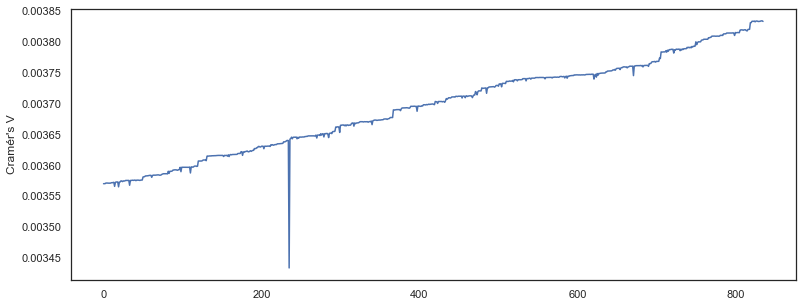

In [21]:
# Visualize the results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel("Cramér's V")

sns.lineplot(x=range(len(scores)), y=scores)